In [2]:
## Ursan Tchouteng Njike
## MS C289
## Project 4

## Importing usefull libraries
import numpy as np
import matplotlib.pyplot as plt
 
##initializing constants
a = 0.8 #                                 <---           Joule heating absorption coefficient
A_1 = 2.5*10**-4 #                        <---           densification rate parameter
A_2 = 1.5 #                               <---           plasticity rate parameter
beta = 2*10**-5 # K^-1                    <---           coefficient of thermal expansion
C = 850 #JKg-1K-1                         <---           heat capacity
d_0 = 0.67 #                              <---           initial densification parameter
J = np.matrix([0,0,10**7]) #A/m^2         <---           electrical current density
kappa_0 = 85*10**9 #Pa                    <---           dense material bulk modulus
mhu_0 = 22*10**9 #Pa                      <---           dense material shear modulus
P1 = 10**-3 #                             <---           elasticity thermal parameter
P2 = 10**-3 #                             <---           conductivity thermal parameter
P3 = 10**-3 #                             <---           densification thermal parameter
P4 = 10**-3 #                             <---           yield strength thermal parameter

q_0 = np.matrix([[-10],
                [-10],
                [-10]]) #J/(sm^2)         <---           heat flux

rho_0 = 2350 #kg/m^3                      <---           reference material density

sigma_o_c = np.matrix([[10**5, 0, 0],
                      [0, 10**5, 0],
                      [0, 0, 10**5]]) #S/m <---          dense material electrical conductivity

sigma_o_d = 1.2*10**6 #Pa                  <---          reference densification threshold

sigma_o_y = 38*10**6 #Pa                   <---          reference yield strength

theta_0 = 300 #K                           <---          initial temperature

I = np.matrix([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]]) #                <---          identity matrix


In [8]:
## Process Simulation

# initializing variable
p=[] #Pa <---  pressure
d=[d_0] # <--- densification parameter
theta = [theta_0] #K <--- temperature
sigma_dev_norm = [] # <--- deviatory stress
E_p = np.matrix([[0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.]]) #          <---           Plastic strain

E_pdot = np.matrix([[0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.]]) #          <---           Plastic strain rate

E_p_norm = [] #                            <---           Plastic strain 2 norm

theta_dot = 0 #                            <---           temperature rate
d_dot = 0 #                                <---           densification rate

# initializing the duration and time steps
t = np.arange(0,1.0001,10**-4) #           <---           time

#=========================================================================================================================
#iterating over 1s with 10^-4 s timestep
for ti in t:

    #updating theta
    theta.append(theta[-1] + 10**-4*theta_dot) 
#     print('theta: ', theta[-1])
    
    #updating d
    di = d[-1] + 10**-4*d_dot
    if (di >= 0 and di <= 1):
        d.append(d[-1] + 10**-4*d_dot) 
    else:
        d.append(0)
#     print('d: ', d[-1])
        
    #updating E_p
    E_p_norm.append(np.linalg.norm(E_p, ord = 2))
    E_p = E_p + 10**-4*E_pdot
    
    # evaluating the deformation gradient at each time step
    F = np.matrix([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1-0.15*ti]])
    
    # evaluating the Jacobien
    Ja = np.linalg.det(F)
    
    
    #evaluating c_1 and c_2 for the elasticity tensor
    c_1 = kappa_0 + 4/3*mhu_0
    c_2 = kappa_0 - 2/3*mhu_0
    
    # evaluating the elasticity tensor at each time step 
    E_o = np.matrix([[c_1, c_2, c_2, 0, 0, 0],
                        [c_2, c_1, c_2, 0, 0, 0], 
                        [c_2, c_2, c_1, 0, 0, 0], 
                        [0, 0, 0, mhu_0, 0, 0],
                        [0, 0, 0, 0, mhu_0, 0], 
                        [0, 0, 0, 0, 0, mhu_0]])
    
    #updating E_ the elasticity tensor
    E_ = (1-d[-1])*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*E_o
    
    #updating sigma_d
    sigma_d = sigma_o_d*np.exp(-P3*(theta[-1]-theta_0)/theta_0)
    
    #updating sigma_y
    sigma_y = sigma_o_y*np.exp(-P4*(theta[-1]-theta_0)/theta_0)
    
    #updating sigma_c
    sigma_c = (1-d[-1])*np.exp(-P2*(theta[-1]-theta_0)/theta_0)*sigma_o_c
    
    
    # Calculating E
    E = 0.5*(F.T*F - I)
    
    # calculating E_theta
    E_theta = beta*(theta[-1]-theta_0)*I
    
    # calculating E_e
    E_e = E - E_p - E_theta   
    
    # Transforming E_e to E_eflat
    E_e_flat = np.matrix([[E_e[0,0]],
                          [E_e[1,1]],
                          [E_e[2,2]], 
                          [2*E_e[0,1]], 
                          [2*E_e[0,2]], 
                          [2*E_e[1,2]]])
    
    
    #calculating S flat
    Stemp = E_*E_e_flat
    
    # transforming to 3X3 S
    S = np.matrix([[Stemp[0,0], Stemp[3,0], Stemp[4,0]],
                       [Stemp[3,0], Stemp[1,0], Stemp[5,0]],
                       [Stemp[4,0], Stemp[5,0], Stemp[2,0]]])
    
    # calculating sigma   
    temp = F*S*(F.T)
    sigma = temp/Ja
    
    
    # calculating pressure
    p.append(-np.trace(sigma)/3)
#     print('p: ', p[-1])
    
    # calculating deviatory stress
    sigma_dev = sigma + p[-1]*I
    
    # calculating d_dot
    if (np.absolute(np.trace(sigma)/3)>sigma_d and np.trace(sigma)/3<=0 and d[-1]>0):
        d_dot = -A_1*(np.absolute(np.trace(sigma)/3)/sigma_d-1)
    else:
        d_dot = 0
        
    
    # calculating lambda_pdot
    sigma_dev_norm.append(np.linalg.norm(sigma_dev, ord='fro'))
    
    if sigma_dev_norm[-1]>sigma_y:
        lambda_pdot = A_2*(sigma_dev_norm[-1]/sigma_y -1)
    else:
        lambda_pdot = 0
    
    # calculating E_pdot
    F_inv = np.linalg.inv(F)
    e_pdot = lambda_pdot*sigma_dev/sigma_dev_norm[-1]
    if ti ==0:
        E_pdot = E_p
    else: E_pdot = Ja*F_inv*e_pdot*(F_inv.T)
        
    # Joule heating power
    H = 3*a/np.trace(sigma_c)*J*J.T
    
    #current contribution to heat
    JH = Ja*H[0,0]
    
    #divergence of heat flux
    divq_0 = np.sum(q_0)
    
    # elastic strain S:E_pdot heat generation
    S_Epdot = (Stemp.T*np.matrix([[E_pdot[0,0]],
                            [E_pdot[1,1]],
                            [E_pdot[2,2]], 
                            [2*E_pdot[0,1]], 
                            [2*E_pdot[0,2]], 
                            [2*E_pdot[1,2]]]))[0,0]

 
    # Elastic Strain multiplied by reference Green Lagrange strain multiplied by Elastic Strain
    EeEoEe = E_e_flat.T*E_o*E_e_flat
    EeEoEe_ = (d_dot/2)*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*EeEoEe[0,0]

    
    #numerator
    theta_dot_numerator = S_Epdot + EeEoEe_ - divq_0 + JH
    
    #denominator
    theta_dot_denominator = rho_0 * C - beta * np.trace(S) - ((1-d[-1])/(2*theta_0))*P1*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*EeEoEe
    
    # calculating theta_dot
    theta_dot = theta_dot_numerator/theta_dot_denominator
    theta_dot = theta_dot[0,0]


    

    

C:\Users\njike\AppData\Local\Temp/ipykernel_15600/2258615171.py:133: RuntimeWarning: invalid value encountered in true_divide
  e_pdot = lambda_pdot*sigma_dev/sigma_dev_norm[-1]


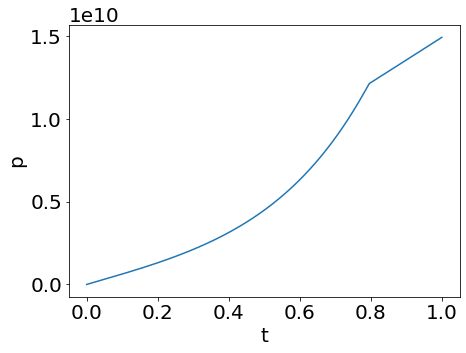

In [9]:
# Plotting the pressure over time
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 5))
plt.plot(t, p)
plt.xlabel('t')
plt.ylabel('p')
fig = plt.gcf()
fig.savefig('pvst')

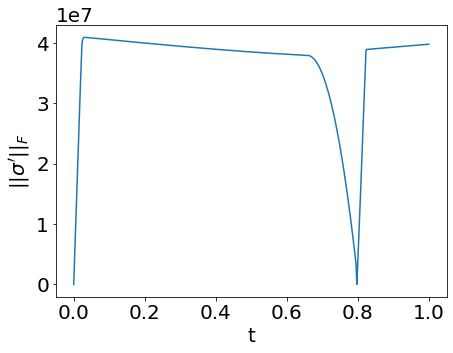

In [9]:
#plotting the frobenius norm of the deviatory stress over time
plt.figure(figsize=(7, 5))
plt.plot(t, sigma_dev_norm)
plt.xlabel('t')
plt.ylabel("$||\sigma'||_F$")
plt.savefig('devvst')

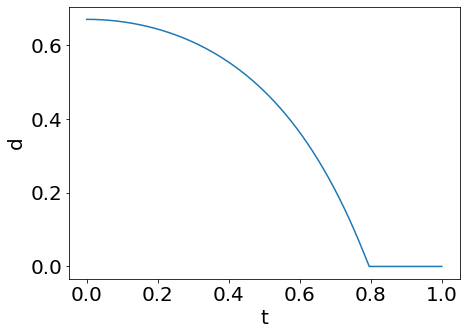

In [10]:
# Plotting the densification over time
plt.figure(figsize=(7, 5))
plt.plot(t, d[1:])
plt.xlabel('t')
plt.ylabel("d")
plt.savefig('dvst')

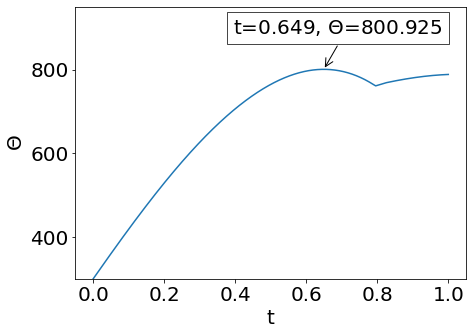

In [13]:
# plotting the temperature over time
plt.figure(figsize=(7, 5))
plt.plot(t, theta[1:])
plt.xlabel('t')
plt.ylabel("$\Theta$")

# Creating max value annotation
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= "t={:.3f}, $\Theta$={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(t,theta[1:])

plt.ylim(300,950)
fig = plt.gcf()
plt.savefig('thetavst')
plt.show()

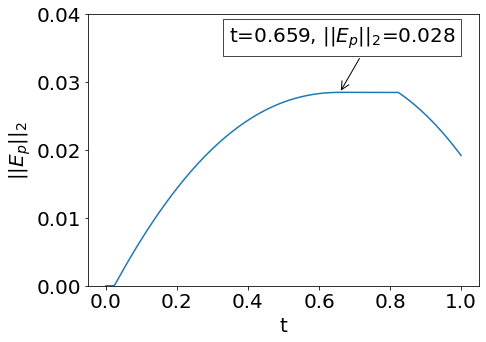

In [12]:
# Plotting the 2 norm of the plastic strain over time
plt.figure(figsize=(7, 5))
plt.plot(t, E_p_norm)
plt.xlabel('t')
plt.ylabel("$||E_p||_2$")

# Creating max value annotation
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= "t={:.3f}, $||E_p||_2$={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(t,E_p_norm)

plt.ylim(0,0.04)
plt.savefig('Pstravst')
plt.show()

In [12]:
#Creating a function using the same process simulation as before to implement a genetic algorithm
def num_sim(d_gen, J_gen):

    ##initializing constants
    a = 0.8
    A_1 = 2.5*10**-4
    A_2 = 1.5
    beta = 2*10**-5 # K^-1
    C = 850 #JKg-1K-1
    J = np.matrix([0,0,J_gen]) #A/m^2
    kappa_0 = 85*10**9 #Pa
    mhu_0 = 22*10**9 #Pa
    P1 = 10**-3
    P2 = 10**-3
    P3 = 10**-3
    P4 = 10**-3

    q_0 = np.matrix([[-10],
                    [-10],
                    [-10]]) #J/(sm^2)

    rho_0 = 2350 #kg/m^3

    sigma_o_c = np.matrix([[10**5, 0, 0],
                          [0, 10**5, 0],
                          [0, 0, 10**5]]) #S/m

    sigma_o_d = 1.2*10**6 #Pa

    sigma_o_y = 38*10**6 #Pa

    theta_0 = 300 #K

    I = np.matrix([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]]) # identity matrix

    # initializing variable
    p=[]
    d=[d_gen] # densification parameter
    theta = [theta_0] #temperature
    sigma_dev_norm = []
    E_p = np.matrix([[0., 0., 0.],
                     [0., 0., 0.],
                     [0., 0., 0.]])

    E_pdot = np.matrix([[0., 0., 0.],
                     [0., 0., 0.],
                     [0., 0., 0.]])

    E_p_norm = []

    theta_dot = 0
    d_dot = 0

    # initializing the duration and time steps
    t = np.arange(0,1.0001,10**-4)
#=========================================================================================================================
    #iterating over 1s with 10^-4 s timestep
    for ti in t:

        #updating theta
        theta.append(theta[-1] + 10**-4*theta_dot)
    #     print('theta: ', theta[-1])

        #updating d
        di = d[-1] + 10**-4*d_dot
        if (di >= 0 and di <= 1):
            d.append(d[-1] + 10**-4*d_dot)
        else:
            d.append(0)
    #     print('d: ', d[-1])

        #updating E_p
        E_p_norm.append(np.linalg.norm(E_p, ord = 2))
        E_p = E_p + 10**-4*E_pdot

        # evaluating the deformation gradient at each time step
        F = np.matrix([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1-0.15*ti]])

        # evaluating the Jacobien
        Ja = np.linalg.det(F)


        #evaluating c_1 and c_2 for the elasticity tensor
        c_1 = kappa_0 + 4/3*mhu_0
        c_2 = kappa_0 - 2/3*mhu_0

        # evaluating the elasticity tensor at each time step 
        E_o = np.matrix([[c_1, c_2, c_2, 0, 0, 0],
                            [c_2, c_1, c_2, 0, 0, 0], 
                            [c_2, c_2, c_1, 0, 0, 0], 
                            [0, 0, 0, mhu_0, 0, 0],
                            [0, 0, 0, 0, mhu_0, 0], 
                            [0, 0, 0, 0, 0, mhu_0]])

        #updating E_ the elasticity tensor
        E_ = (1-d[-1])*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*E_o

        #updating sigma_d
        sigma_d = sigma_o_d*np.exp(-P3*(theta[-1]-theta_0)/theta_0)

        #updating sigma_y
        sigma_y = sigma_o_y*np.exp(-P4*(theta[-1]-theta_0)/theta_0)

        #updating sigma_c
        sigma_c = (1-d[-1])*np.exp(-P2*(theta[-1]-theta_0)/theta_0)*sigma_o_c


        # Calculating E
        E = 0.5*(F.T*F - I)

        # calculating E_theta
        E_theta = beta*(theta[-1]-theta_0)*I

        # calculating E_e
        E_e = E - E_p - E_theta   

        # Transforming E_e to E_eflat
        E_e_flat = np.matrix([[E_e[0,0]],
                              [E_e[1,1]],
                              [E_e[2,2]], 
                              [2*E_e[0,1]], 
                              [2*E_e[0,2]], 
                              [2*E_e[1,2]]])


        #calculating S flat
        Stemp = E_*E_e_flat

        # transforming to 3X3 S
        S = np.matrix([[Stemp[0,0], Stemp[3,0], Stemp[4,0]],
                           [Stemp[3,0], Stemp[1,0], Stemp[5,0]],
                           [Stemp[4,0], Stemp[5,0], Stemp[2,0]]])

        # calculating sigma   
        temp = F*S*(F.T)
        sigma = temp/Ja


        # calculating pressure
        p.append(-np.trace(sigma)/3)
    #     print('p: ', p[-1])

        # calculating deviatory stress
        sigma_dev = sigma + p[-1]*I

        # calculating d_dot
        if (np.absolute(np.trace(sigma)/3)>sigma_d and np.trace(sigma)/3<=0 and d[-1]>0):
            d_dot = -A_1*(np.absolute(np.trace(sigma)/3)/sigma_d-1)
        else:
            d_dot = 0


        # calculating lambda_pdot
        sigma_dev_norm.append(np.linalg.norm(sigma_dev, ord='fro'))

        if sigma_dev_norm[-1]>sigma_y:
            lambda_pdot = A_2*(sigma_dev_norm[-1]/sigma_y -1)
        else:
            lambda_pdot = 0

        # calculating E_pdot
        F_inv = np.linalg.inv(F)
        e_pdot = lambda_pdot*sigma_dev/sigma_dev_norm[-1]
        if ti ==0:
            E_pdot = E_p
        else: E_pdot = Ja*F_inv*e_pdot*(F_inv.T)


        H = 3*a/np.trace(sigma_c)*J*J.T

        #current contribution to heat
        JH = Ja*H[0,0]

        #divergence of heat flux
        divq_0 = np.sum(q_0)

        # elastic strain S:E_pdot heat generation
        S_Epdot = (Stemp.T*np.matrix([[E_pdot[0,0]],
                                [E_pdot[1,1]],
                                [E_pdot[2,2]], 
                                [2*E_pdot[0,1]], 
                                [2*E_pdot[0,2]], 
                                [2*E_pdot[1,2]]]))[0,0]



        EeEoEe = E_e_flat.T*E_o*E_e_flat
        EeEoEe_ = (d_dot/2)*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*EeEoEe[0,0]


        #numerator
        theta_dot_numerator = S_Epdot + EeEoEe_ - divq_0 + JH

        #denominator
        theta_dot_denominator = rho_0 * C - beta * np.trace(S) - ((1-d[-1])/(2*theta_0))*P1*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*EeEoEe

        # calculating theta_dot
        theta_dot = theta_dot_numerator/theta_dot_denominator
        theta_dot = theta_dot[0,0]
#==========================================================================================================================
    return np.max(theta), d[-1]              # <---    Returning the max temperature value and the last densification value                 


In [13]:
# Process Optimization
## Importing usefull libraries
import numpy as np
import matplotlib.pyplot as plt

# Initializing genetic algorithm parameters
children = 6
parent = 6
S = 20
G = 100
theta_des = 650 #K
TOL = 10**-6
w_1 = 1000
w_2 = 100

# random number genration
rng = np.random.default_rng()

# generating d array of size S from 0.6 to 0.8
d_gen = 0.4*rng.random((S,1)) + 0.5

# generating J array of size S from 10^6 to 10^7
J_gen = 10**7*rng.random((S,1))

# organizing d and J values generated for the genetic algorithm
Lambda = np.hstack([d_gen, J_gen])

# running the numerical simulation over the generated population
sim_res = [num_sim(Lambda[i,0],Lambda[i,1]) for i in range(S)]

# evaluating the cost of each member of the population
new_pi = [w_1*((sim_res[i][0]-theta_des)/theta_des)**2 + w_2*sim_res[i][1] for i in range(S)]

C:\Users\njike\AppData\Local\Temp/ipykernel_6272/2717957894.py:167: RuntimeWarning: invalid value encountered in true_divide
  e_pdot = lambda_pdot*sigma_dev/sigma_dev_norm[-1]


In [7]:
# initializing the generation count
g = 1

# labeling the data
dtype = [('Lambda1', float), ('Lambda2', float), ('new_pi', float)]

# Organzing the data for each member of the population
Pi=[]
for _ in range(S):
    Pi.append((Lambda[_][0], Lambda[_][1], new_pi[_]))

# converting to an array and sorti the list of the population over the new pi
Pi1 = np.array(Pi, dtype=dtype)
Sorted_Pi = np.sort(Pi1, order='new_pi')

---------------------generation 1 ---------------------
d:  0.7404964563566162 
J:  7880428.866151071
PI_min:  10.724238913271176


C:\Users\njike\AppData\Local\Temp/ipykernel_14140/1173209467.py:166: RuntimeWarning: invalid value encountered in true_divide
  e_pdot = lambda_pdot*sigma_dev/sigma_dev_norm[-1]


---------------------generation 2 ---------------------
d:  0.7440915282035325 
J:  6980853.583101917
PI_min:  0.44258621333309733
Parent_avg:  4.425035467109772
---------------------generation 3 ---------------------
d:  0.7249963492089386 
J:  7449867.458558881
PI_min:  0.008944214824970504
Parent_avg:  0.2435932863667816
---------------------generation 4 ---------------------
d:  0.6898555947883057 
J:  7969638.823998788
PI_min:  0.0005786415773650483
Parent_avg:  0.03044089687755319
---------------------generation 5 ---------------------
d:  0.6898555947883057 
J:  7969638.823998788
PI_min:  0.0005786415773650483
Parent_avg:  0.007597008249928573
---------------------generation 6 ---------------------
d:  0.6898555947883057 
J:  7969638.823998788
PI_min:  0.0005786415773650483
Parent_avg:  0.0012419077622953117
---------------------generation 7 ---------------------
d:  0.6898555947883057 
J:  7969638.823998788
PI_min:  0.0005786415773650483
Parent_avg:  0.0005812562037379534
-----

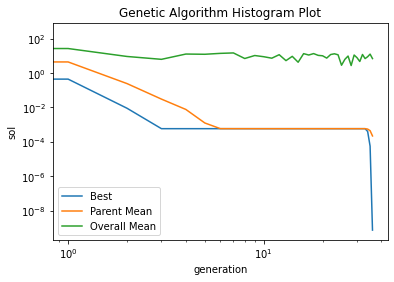

In [8]:
g = 1

# initializing variable tracking the GA performance
Parent_avg = []
PI_avg = []
PI_min = []
Sol1 = []
Sol2 = []

PI_min.append(Sorted_Pi['new_pi'][0])
Parent_avg.append(Sorted_Pi['new_pi'][0:6].mean())
PI_avg.append(Sorted_Pi['new_pi'].mean())
Sol1.append(Sorted_Pi['Lambda1'][0])
Sol2.append(Sorted_Pi['Lambda2'][0])
print('---------------------generation', g, '---------------------')
print('d: ', Sol1[-1], '\nJ: ', Sol2[-1])
print('PI_min: ', PI_min[-1])
#==========================================================================================================================
# genetic algorithm iteration
while PI_min[-1]>=TOL and g<G:
    g+=1
    Lamda = []
    for p in 2*np.arange(0,3):
        phi1 = rng.random()
        phi2 = rng.random()
        
        ## mating parents to produce children that replaces worse parents
        Sorted_Pi['Lambda1'][p+6] =  phi1*Sorted_Pi['Lambda1'][p] + (1-phi1)*Sorted_Pi['Lambda1'][p+1]
        Sorted_Pi['Lambda2'][p+6] =  phi1*Sorted_Pi['Lambda2'][p] + (1-phi1)*Sorted_Pi['Lambda2'][p+1]
        Sorted_Pi['Lambda1'][p+7] =  phi2*Sorted_Pi['Lambda1'][p] + (1-phi2)*Sorted_Pi['Lambda1'][p+1]
        Sorted_Pi['Lambda2'][p+7] =  phi2*Sorted_Pi['Lambda2'][p] + (1-phi2)*Sorted_Pi['Lambda2'][p+1]
        
        ##evaluating new pi
        sim_res_child1 = num_sim(Sorted_Pi['Lambda1'][p+6],Sorted_Pi['Lambda2'][p+6])
        sim_res_child2 = num_sim(Sorted_Pi['Lambda1'][p+7],Sorted_Pi['Lambda2'][p+7])
        
        Sorted_Pi['new_pi'][p+6] =  w_1*((sim_res_child1[0]-theta_des)/theta_des)**2 + w_2*sim_res_child1[1]
        Sorted_Pi['new_pi'][p+7] =  w_1*((sim_res_child2[0]-theta_des)/theta_des)**2 + w_2*sim_res_child2[1]
        
        
        
    ## generating new random values
    for N in range(12,S):
        Sorted_Pi['Lambda1'][N] =  0.2*rng.random() + 0.6
        Sorted_Pi['Lambda2'][N] =  2*10**6*rng.random()+6*10**6
        
        ##evaluating new pi
        sim_res_new = num_sim(Sorted_Pi['Lambda1'][N],Sorted_Pi['Lambda2'][N])
        Sorted_Pi['new_pi'][N] =  w_1*((sim_res_new[0]-theta_des)/theta_des)**2 + w_2*sim_res_new[1]
        
    ## sorting and appending values    
    Sorted_Pi = np.sort(Sorted_Pi, order='new_pi')
    PI_min.append(Sorted_Pi['new_pi'][0])
    Parent_avg.append(Sorted_Pi['new_pi'][0:6].mean())
    PI_avg.append(Sorted_Pi['new_pi'].mean())
    Sol1.append(Sorted_Pi['Lambda1'][0])
    Sol2.append(Sorted_Pi['Lambda2'][0])
    print('---------------------generation', g, '---------------------')
    print('d: ', Sol1[-1], '\nJ: ', Sol2[-1])
    print('PI_min: ', PI_min[-1])
    print('Parent_avg: ', Parent_avg[-1])
#==========================================================================================================================
# Plotting solution
plt.plot(PI_min, label = 'Best')
plt.plot(Parent_avg, label = 'Parent Mean')
plt.plot(PI_avg, label = 'Overall Mean')
# plt.plot(Sol1, label = '$\lambda1$')
# plt.plot(Sol2, label = '$\lambda2$')
# naming the x axis
plt.xlabel('generation')
# naming the y axis
plt.ylabel('sol')
# giving a title to my graph
plt.title('Genetic Algorithm Histogram Plot')
plt.loglog()
plt.legend()
plt.savefig('figure1')
plt.show()

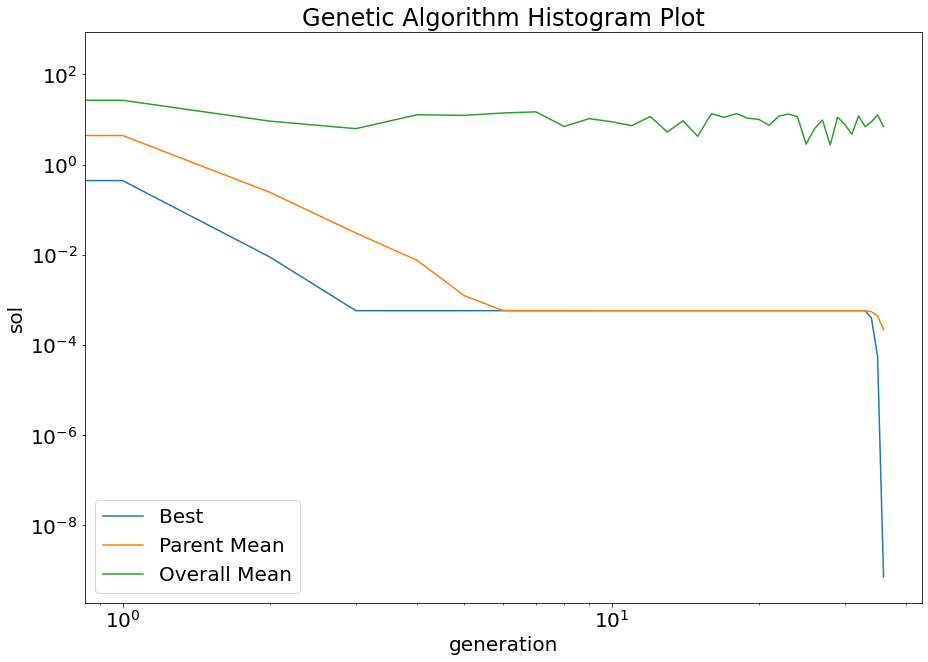

In [9]:
plt.plot(PI_min, label = 'Best')
plt.plot(Parent_avg, label = 'Parent Mean')
plt.plot(PI_avg, label = 'Overall Mean')
# plt.plot(Sol1, label = '$\lambda1$')
# plt.plot(Sol2, label = '$\lambda2$')
# naming the x axis
plt.xlabel('generation')
# naming the y axis
plt.ylabel('sol')
# giving a title to my graph
plt.title('Genetic Algorithm Histogram Plot')
plt.loglog()
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10.5)
fig.savefig('test3png.png', dpi=80)

In [12]:
# numerical simulation for the best d and J values
# this simulation returns two list with one containing temperature and the other containing pressure at different time steps
# This function is almost identical to the process simulation
def num_sim_best(d_gen, J_gen):

    ##initializing constants
    a = 0.8
    A_1 = 2.5*10**-4
    A_2 = 1.5
    beta = 2*10**-5 # K^-1
    C = 850 #JKg-1K-1
    J = np.matrix([0,0,J_gen]) #A/m^2
    kappa_0 = 85*10**9 #Pa
    mhu_0 = 22*10**9 #Pa
    P1 = 10**-3
    P2 = 10**-3
    P3 = 10**-3
    P4 = 10**-3

    q_0 = np.matrix([[-10],
                    [-10],
                    [-10]]) #J/(sm^2)

    rho_0 = 2350 #kg/m^3

    sigma_o_c = np.matrix([[10**5, 0, 0],
                          [0, 10**5, 0],
                          [0, 0, 10**5]]) #S/m

    sigma_o_d = 1.2*10**6 #Pa

    sigma_o_y = 38*10**6 #Pa

    theta_0 = 300 #K

    I = np.matrix([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]]) # identity matrix

    # initializing variable
    p=[]
    d=[d_gen] # densification parameter
    theta = [theta_0] #temperature
    sigma_dev_norm = []
    E_p = np.matrix([[0., 0., 0.],
                     [0., 0., 0.],
                     [0., 0., 0.]])

    E_pdot = np.matrix([[0., 0., 0.],
                     [0., 0., 0.],
                     [0., 0., 0.]])

    E_p_norm = []

    theta_dot = 0
    d_dot = 0

    # initializing the duration and time steps
    t = np.arange(0,1.0001,10**-4)

    #iterating over 1s with 10^-4 s timestep
    for ti in t:

        #updating theta
        theta.append(theta[-1] + 10**-4*theta_dot)
    #     print('theta: ', theta[-1])

        #updating d
        di = d[-1] + 10**-4*d_dot
        if (di >= 0 and di <= 1):
            d.append(d[-1] + 10**-4*d_dot)
        else:
            d.append(0)
    #     print('d: ', d[-1])

        #updating E_p
        E_p_norm.append(np.linalg.norm(E_p, ord = 2))
        E_p = E_p + 10**-4*E_pdot

        # evaluating the deformation gradient at each time step
        F = np.matrix([[1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1-0.15*ti]])

        # evaluating the Jacobien
        Ja = np.linalg.det(F)


        #evaluating c_1 and c_2 for the elasticity tensor
        c_1 = kappa_0 + 4/3*mhu_0
        c_2 = kappa_0 - 2/3*mhu_0

        # evaluating the elasticity tensor at each time step 
        E_o = np.matrix([[c_1, c_2, c_2, 0, 0, 0],
                            [c_2, c_1, c_2, 0, 0, 0], 
                            [c_2, c_2, c_1, 0, 0, 0], 
                            [0, 0, 0, mhu_0, 0, 0],
                            [0, 0, 0, 0, mhu_0, 0], 
                            [0, 0, 0, 0, 0, mhu_0]])

        #updating E_ the elasticity tensor
        E_ = (1-d[-1])*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*E_o

        #updating sigma_d
        sigma_d = sigma_o_d*np.exp(-P3*(theta[-1]-theta_0)/theta_0)

        #updating sigma_y
        sigma_y = sigma_o_y*np.exp(-P4*(theta[-1]-theta_0)/theta_0)

        #updating sigma_c
        sigma_c = (1-d[-1])*np.exp(-P2*(theta[-1]-theta_0)/theta_0)*sigma_o_c


        # Calculating E
        E = 0.5*(F.T*F - I)

        # calculating E_theta
        E_theta = beta*(theta[-1]-theta_0)*I

        # calculating E_e
        E_e = E - E_p - E_theta   

        # Transforming E_e to E_eflat
        E_e_flat = np.matrix([[E_e[0,0]],
                              [E_e[1,1]],
                              [E_e[2,2]], 
                              [2*E_e[0,1]], 
                              [2*E_e[0,2]], 
                              [2*E_e[1,2]]])


        #calculating S flat
        Stemp = E_*E_e_flat

        # transforming to 3X3 S
        S = np.matrix([[Stemp[0,0], Stemp[3,0], Stemp[4,0]],
                           [Stemp[3,0], Stemp[1,0], Stemp[5,0]],
                           [Stemp[4,0], Stemp[5,0], Stemp[2,0]]])

        # calculating sigma   
        temp = F*S*(F.T)
        sigma = temp/Ja


        # calculating pressure
        p.append(-np.trace(sigma)/3)
    #     print('p: ', p[-1])

        # calculating deviatory stress
        sigma_dev = sigma + p[-1]*I

        # calculating d_dot
        if (np.absolute(np.trace(sigma)/3)>sigma_d and np.trace(sigma)/3<=0 and d[-1]>0):
            d_dot = -A_1*(np.absolute(np.trace(sigma)/3)/sigma_d-1)
        else:
            d_dot = 0


        # calculating lambda_pdot
        sigma_dev_norm.append(np.linalg.norm(sigma_dev, ord='fro'))

        if sigma_dev_norm[-1]>sigma_y:
            lambda_pdot = A_2*(sigma_dev_norm[-1]/sigma_y -1)
        else:
            lambda_pdot = 0

        # calculating E_pdot
        F_inv = np.linalg.inv(F)
        e_pdot = lambda_pdot*sigma_dev/sigma_dev_norm[-1]
        if ti ==0:
            E_pdot = E_p
        else: E_pdot = Ja*F_inv*e_pdot*(F_inv.T)


        H = 3*a/np.trace(sigma_c)*J*J.T

        #current contribution to heat
        JH = Ja*H[0,0]

        #divergence of heat flux
        divq_0 = np.sum(q_0)

        # elastic strain S:E_pdot heat generation
        S_Epdot = (Stemp.T*np.matrix([[E_pdot[0,0]],
                                [E_pdot[1,1]],
                                [E_pdot[2,2]], 
                                [2*E_pdot[0,1]], 
                                [2*E_pdot[0,2]], 
                                [2*E_pdot[1,2]]]))[0,0]



        EeEoEe = E_e_flat.T*E_o*E_e_flat
        EeEoEe_ = (d_dot/2)*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*EeEoEe[0,0]


        #numerator
        theta_dot_numerator = S_Epdot + EeEoEe_ - divq_0 + JH

        #denominator
        theta_dot_denominator = rho_0 * C - beta * np.trace(S) - ((1-d[-1])/(2*theta_0))*P1*np.exp(-P1*(theta[-1]-theta_0)/theta_0)*EeEoEe

        # calculating theta_dot
        theta_dot = theta_dot_numerator/theta_dot_denominator
        theta_dot = theta_dot[0,0]
    return theta, d

t = np.arange(0,1.0001,10**-4)
theta, d = num_sim_best(0.700177,7809034)

C:\Users\njike\AppData\Local\Temp/ipykernel_15600/2388726157.py:169: RuntimeWarning: invalid value encountered in true_divide
  e_pdot = lambda_pdot*sigma_dev/sigma_dev_norm[-1]


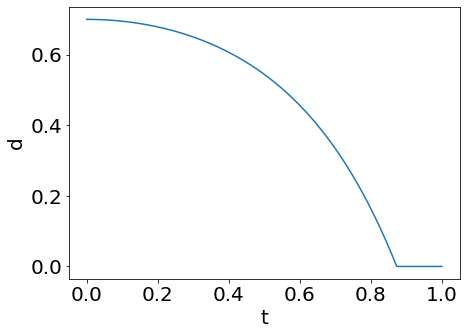

In [18]:
# plotting the best densification over time
plt.figure(figsize=(7, 5))
plt.plot(t, d[1:])
plt.xlabel('t')
plt.ylabel("d")
plt.savefig('doptvst')

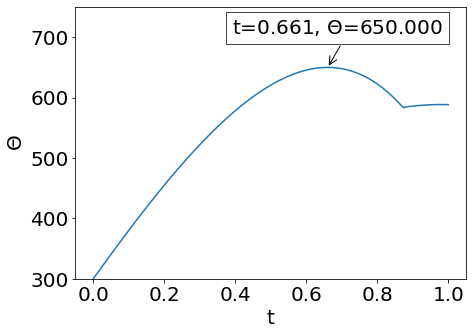

In [19]:
# plotting the best temperature over time
plt.figure(figsize=(7, 5))
plt.plot(t, theta[1:])
plt.xlabel('t')
plt.ylabel("$\Theta$")

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= "t={:.3f}, $\Theta$={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(t,theta[1:])

plt.ylim(300,750)
plt.savefig('thetaoptvst')
plt.show()

In [17]:
w_1 = 1000
w_2 = 100
theta_des = 650 #K

theta_max = np.max(theta)
d_f = d[-1]
cost_function = w_1*((theta_max-theta_des)/theta_des)**2 + w_2*d_f
cost_function

1.3386881705783038e-10